# Градиентный спуск

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.  

In [1]:
import abc

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для обучения линейной регрессии необходим функционал ошибки, определим интерфейс для последующих реализаций.

In [2]:
class BaseLoss(abc.ABC):
    """Base class for losses"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """Calculate loss value based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            number, loss value
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """Calculate gradient vector based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            gradients for weights, (n_features,)
        """
        raise NotImplementedError

Вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return np.square(X @ w - y).mean()

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return (2 / X.shape[0]) * X.T @ (X @ w - y)

In [4]:
# Проведем небольшую проверку реализации

# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

In [5]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> np.ndarray:
    """Weights optimization with gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w = w_init.copy()
    history = np.zeros((n_iterations + 1, w_init.shape[0]))
    history[0] = w

    for i in range(1, n_iterations + 1):
        w -= lr * loss.calc_grad(X, y, w)
        history[i] = w

    return history

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [7]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649493


In [8]:
def plot_gd(w_list: np.ndarray, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """Plot gradient descent trajectory

    Args:
        w_list: weights history, (n_iterations, n_features)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

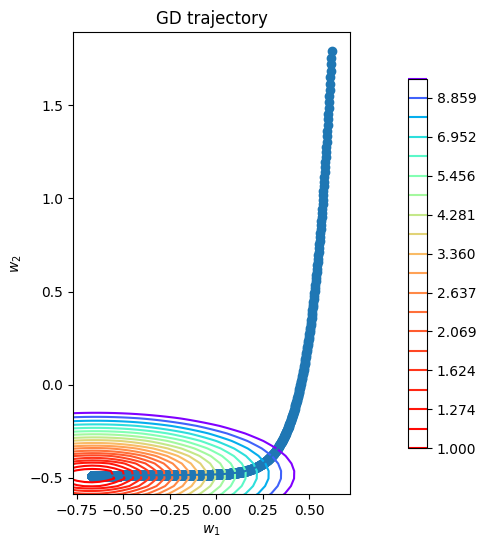

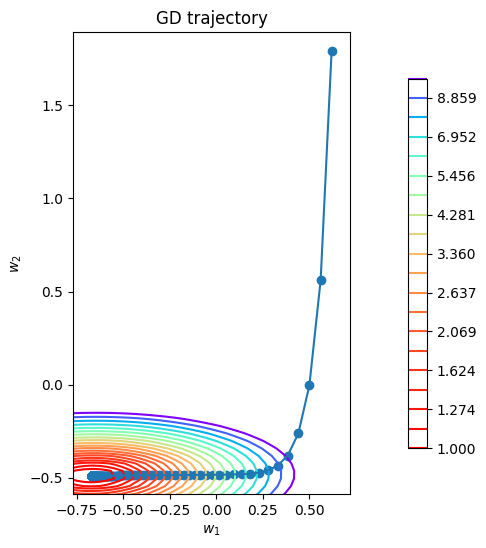

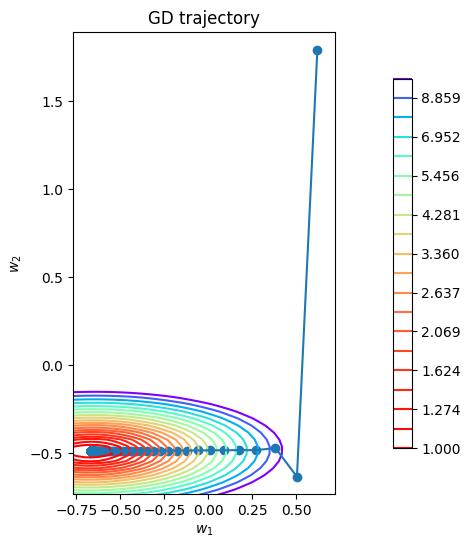

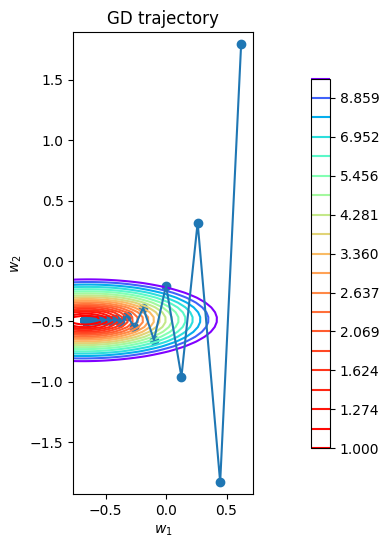

In [9]:
loss = MSELoss()
lrs = np.linspace(0.0001, 0.01, 4)

for lr in lrs:
  history_w = gradient_descent(w_init, X, y, loss, lr)
  plot_gd(history_w, X, y, loss)

**Чем меньше lr, тем медленнее будеть происходить обучение, риск не найти глобальный минимум . Чем больше - быстрее обучение, но больший шанс "перепрыгнуть" минимум. При правильном lr - точно есть сходимость.**

Теперь реализуем стохастический градиентный спуск. Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [10]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with stochastic gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """

    w = w_init.copy()
    history = np.zeros((n_iterations + 1, w_init.shape[0]))
    history[0] = w

    for i in range(1, n_iterations + 1):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        w -= lr * loss.calc_grad(X_batch, y_batch, w)
        history[i] = w

    return history

При помощи функций `stochastic_gradient_descent` и `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

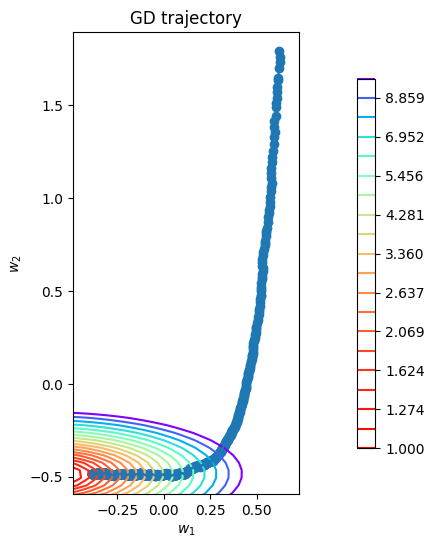

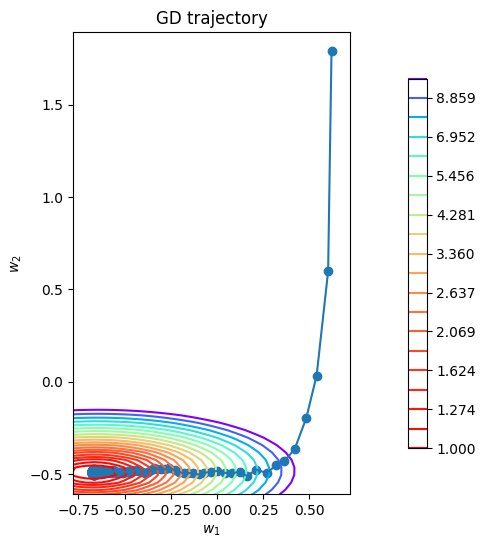

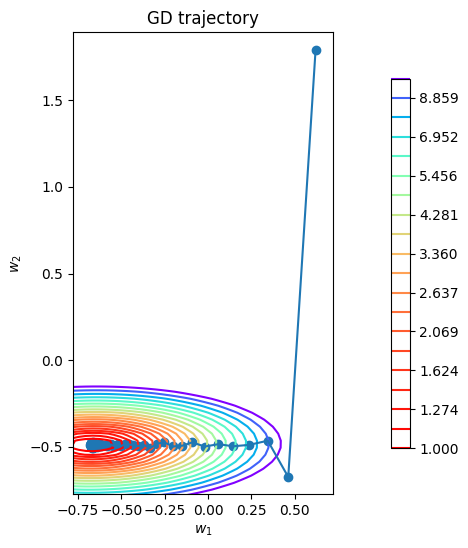

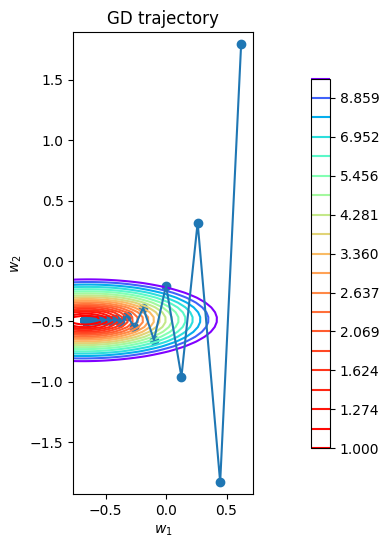

In [11]:
loss = MSELoss()
lrs = np.linspace(0.0001, 0.01, 4)
batch_sizes = [10, 100, 200, 300]

for lr, batch_size in zip(lrs, batch_sizes):
  history_w = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size)
  plot_gd(history_w, X, y, loss)

**lr так же определяет длину шага. batch_size влияет на точность оценки градиента: при маленьком увеличивается шум - точность меньше.**

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуйте SGD на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [12]:
def stochastic_gradient_descent_with_decay(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with SGD and learning rate decay

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        p: learning rate decay factor, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    
    w = w_init.copy()
    history = np.zeros((n_iterations + 1, w_init.shape[0]))
    history[0] = w

    for i in range(1, n_iterations + 1):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]

        lr_i = lr * ((1 / (1 + i)) ** p)
        w -= lr_i * loss.calc_grad(X_batch, y_batch, w)
        history[i] = w

    return history

При помощи новой функции `stochastic_gradient_descent_with_decay` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

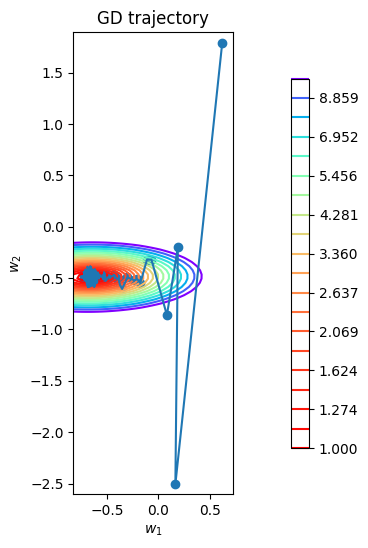

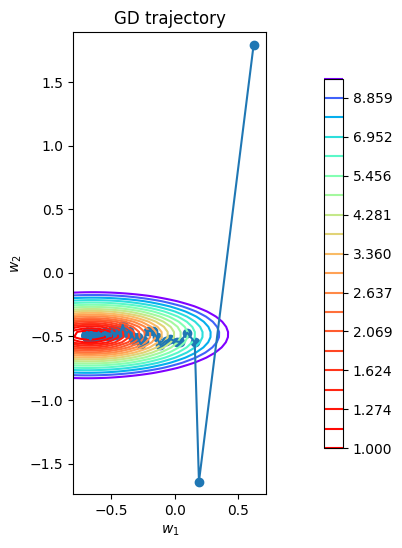

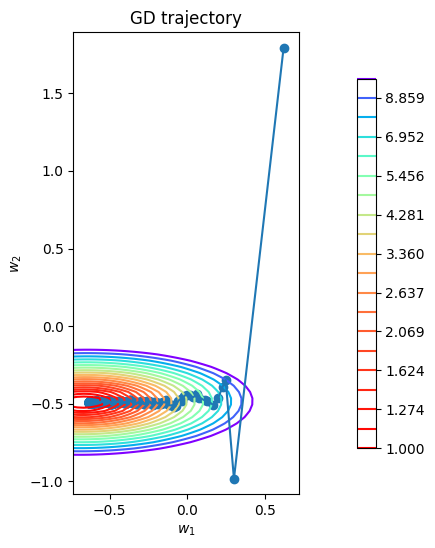

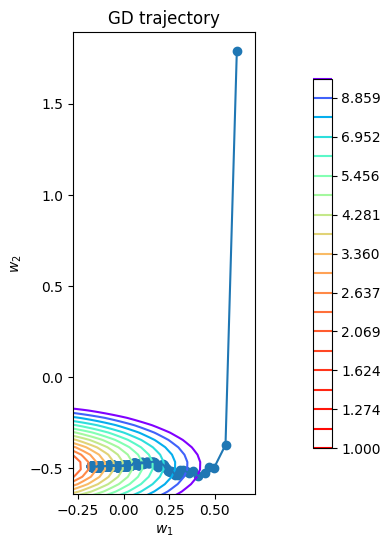

In [13]:
lr = 0.01
batch_size = 10
list_p = np.linspace(0.1, 1, 4)

for p in list_p:
  history_w = stochastic_gradient_descent_with_decay(w_init, X, y, loss, lr, batch_size, p)
  plot_gd(history_w, X, y, loss)

**p влияет на длину шага на каждой итерации. Чем меньше p, тем больше будут шаги на конкретной итерации по сравнению с большим p. При слишком большом и слишком маленьком p не будет сходимости: в первом случае минимум не будет достигнут, во втором $-$ "перепрыгнут"**

Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

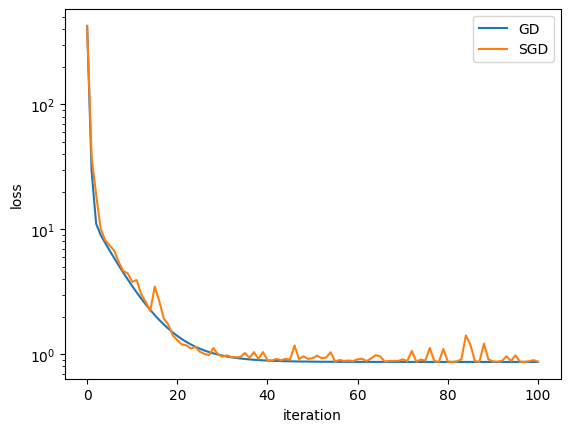

In [14]:
gd_w_list = gradient_descent(w_init, X, y, loss, 0.005, n_iterations=100)
sgd_w_list = stochastic_gradient_descent(w_init, X, y, loss, 0.005, 10, n_iterations=100)

gd_loss = [loss.calc_loss(X, y, w) for w in gd_w_list]
sgd_loss = [loss.calc_loss(X, y, w) for w in sgd_w_list]

plt.plot(gd_loss, label="GD")
plt.plot(sgd_loss, label="SGD")

plt.ylabel('loss')
plt.xlabel('iteration')

plt.yscale('log')
plt.legend()
plt.show()

**Основное преимущество SGD $-$ быстрое вычисление градиента и меньшие затраты памяти на каждой итерации, а также возможность "выйти" из локального минимума. Этого на графике не видно. Видно, что SGD сходится немного раньше чем GD, но график SGD более шумный из-за выбора относительно небольшого размера батча.**

## Часть 2. Линейная регрессия (5 баллов)

Напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`. Не забывайте про единичный признак!

В методе `predict` мы будем применять нашу регрессию к датасету,

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin


class LinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, loss: BaseLoss, lr: float = 0.1, **kwargs) -> None:
        self.loss = loss
        self.lr = lr

        if 'loss__coef' in kwargs and hasattr(self.loss, 'coef'):
            self.loss.coef = kwargs['loss__coef']
        
        if 'loss__eps' in kwargs and hasattr(self.loss, 'eps'):
            self.loss.coef = kwargs['loss__eps']

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)

        ones_column = np.ones((X.shape[0], 1))
        X = np.hstack([X, ones_column])

        w_init = np.zeros(X.shape[1])

        self.w = gradient_descent(w_init, X, y, self.loss, self.lr)[-1]
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"

        X = np.asarray(X)

        ones_column = np.ones((X.shape[0], 1))
        X = np.hstack([X, ones_column])
            
        return X @ self.w
    
    def get_params(self, deep=True):
        params = {"loss": self.loss, "lr": self.lr}

        if hasattr(self.loss, "coef"):
            params["loss__coef"] = self.loss.coef

        if hasattr(self.loss, "eps"):
            params["loss__eps"] = self.loss.eps

        return params

    def set_params(self, **params):
        if "loss" in params:
            self.loss = params["loss"]

        if "lr" in params:
            self.lr = params["lr"]

        if "loss__coef" in params and hasattr(self.loss, "coef"):
            self.loss.coef = params["loss__coef"]

        if "loss__eps" in params and hasattr(self.loss, "eps"):
            self.loss.eps = params["loss__eps"]
            
        return self

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [16]:
MSE_linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [17]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [18]:
y = X_raw[25]
X_raw = X_raw.drop([25, "index"], axis=1)

Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)

numeric_features = X_raw.select_dtypes([np.number]).columns
X_train[numeric_features] = X_train[numeric_features].fillna(X_train[numeric_features].mean())
X_test[numeric_features] = X_test[numeric_features].fillna(X_train[numeric_features].mean())

categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

column_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False), categorical), ("scaling", StandardScaler(), numeric_features)]
)

In [20]:
MSE_searcher_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", MSE_linear_regression)])
MSE_searcher_pipeline = MSE_searcher_pipeline.fit(X_train, y_train)

In [21]:
from sklearn.model_selection import GridSearchCV

lrs = np.logspace(-5, -1, 50)
searcher = GridSearchCV(
    MSE_searcher_pipeline, [{"regression__lr": lrs}], scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1
)
searcher.fit(X_train, y_train)

best_lr = searcher.best_params_["regression__lr"]
print("Best lr = %.4f" % best_lr)

/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sash

Best lr = 0.0004


In [22]:
MSE_linear_regression = LinearRegression(MSELoss(), best_lr)
MSE_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", MSE_linear_regression)])

Обучите линейную регрессию на обучающей выборке

In [23]:
MSE_model = MSE_pipeline.fit(X_train, y_train)

Для оценки качества реализуем `r2_score`, который является нормализацией `mean_square_error`.

In [24]:
def r2(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    mse = np.sum(np.square(y_predicted - y_true))
    y_mean = y_true.mean()
    mse_best_const = np.sum(np.square(y_true - y_mean)
)
    return 1 - (mse / mse_best_const)

Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке.

In [25]:
y_train_predicted = MSE_model.predict(X_train)
print(f"R2-score on train: {r2(y_train, y_train_predicted)}")

y_test_predicted = MSE_model.predict(X_test)
print(f"R2-score on test: {r2(y_test, y_test_predicted)}")

R2-score on train: 0.9529743843095974
R2-score on test: 0.9215687485655379


/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак).

**Вопрос**: надо ли регуляризовывать bias?

**Ответ**: **Нет, bias не связан с признаками, он смещает предсказание модели.**

Не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [26]:
class MSEL2Loss(BaseLoss, BaseEstimator):
    def __init__(self, coef: float = 1.0):
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return np.square(X @ w - y).mean() + self.coef * np.sum(np.square(w[:-1]))

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        w_without_bias = w.copy()
        w_without_bias[-1] = 0
        
        return (2 / X.shape[0]) * X.T @ (X @ w - y) + 2 * self.coef * w_without_bias
    
    def get_params(self, deep=True):
        return {"coef": self.coef}
    
    def set_params(self, **params):
        if "coef" in params:
            self.coef = params["coef"]
        return self

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [27]:
MSEL2_linear_regression = LinearRegression(MSEL2Loss(0.005), best_lr)

Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [28]:
MSEL2_searcher_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", MSEL2_linear_regression)])

In [29]:
from sklearn.model_selection import GridSearchCV

msel2_coefs = np.logspace(-4, 1, 50)
searcher = GridSearchCV(
    MSEL2_searcher_pipeline, [{"regression__lr": [best_lr], "regression__loss__coef": msel2_coefs}], scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1
)
searcher.fit(X_train, y_train)

best_msel2_coef = searcher.best_params_["regression__loss__coef"]
print("Best msel2_coef = %.4f" % best_msel2_coef)

/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sash

Best msel2_coef = 0.0910


In [30]:
MSEL2_linear_regression = LinearRegression(MSEL2Loss(best_msel2_coef), best_lr)
MSEL2_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", MSEL2_linear_regression)])

In [31]:
MSEL2_model = MSEL2_pipeline.fit(X_train, y_train)

In [32]:
y_train_predicted = MSEL2_model.predict(X_train)
print(f"R2-score on train: {r2(y_train, y_train_predicted)}")

y_test_predicted = MSEL2_model.predict(X_test)
print(f"R2-score on test: {r2(y_test, y_test_predicted)}")

R2-score on train: 0.9064984651862813
R2-score on test: 0.8473219247747823


/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


**Ухудшились.**

В нашем датасете могут быть выбросы, с ними хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [33]:
class HuberLoss(BaseLoss, BaseEstimator):
    def __init__(self, eps: float) -> None:
        self.eps = eps
    
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        errors = X @ w - y
        loss_values = np.where(np.abs(errors) < self.eps, 
                            (errors ** 2) / 2, 
                            self.eps * (np.abs(errors) - self.eps / 2))
        
        return np.mean(loss_values)

    def _phi_grad(self, z: float) -> float:
        if -self.eps < z < self.eps:
            return z
        
        return self.eps * np.sign(z)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        errors = X @ w - y
        phi_grad_val = np.array([self._phi_grad(z) for z in errors])

        return X.T @ phi_grad_val / X.shape[0]
    
    def get_params(self, deep=True):
        return {"eps": self.eps}
    
    def set_params(self, **params):
        if "eps" in params:
            self.eps = params["eps"]
        return self

Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [34]:
Huber_linear_regression = LinearRegression(HuberLoss(100), best_lr)
Huber_searcher_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", Huber_linear_regression)])

In [35]:
from sklearn.model_selection import GridSearchCV

epss = np.logspace(3, 5, 20)
searcher = GridSearchCV(
    Huber_searcher_pipeline, [{"regression__loss__eps": epss}], scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1
)
searcher.fit(X_train, y_train)

best_eps = searcher.best_params_["regression__loss__eps"]
print("Best eps = %.4f" % best_eps)

/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sash

Best eps = 4281.3324


In [36]:
Huber_linear_regression = LinearRegression(HuberLoss(best_eps), best_lr)
Huber_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", Huber_linear_regression)])

In [37]:
Huber_model = Huber_pipeline.fit(X_train, y_train)

In [38]:
y_train_predicted = Huber_model.predict(X_train)
print(f"R2-score on train: {r2(y_train, y_train_predicted)}")

y_test_predicted = Huber_model.predict(X_test)
print(f"R2-score on test: {r2(y_test, y_test_predicted)}")

R2-score on train: 0.9268251294736307
R2-score on test: 0.8693215764127333


/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/sashka/python_spbu_TP23_sem4/.venv/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Вставьте ваш любимый мем 2025 в ячейку ниже:

In [39]:
# ========== TODO ==========
#      Ваш мем здесь       =
# ==========================